In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE

In [8]:
df = pd.read_csv(r"C:\Users\Manvi\Documents\customer-churn\customer_churn.csv")
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB
None
              Age  Total_Purchase  Account_Manager       Years   Num_Sites  \
count  900.000000      900.000000       900.000000  900.000000  900.000000   
mean    41.816667    10062.824033         0.481111    5.273156    8.587778   
std      6.127560     2408.644532        

In [10]:
print(df)

                Names   Age  Total_Purchase  Account_Manager  Years  \
0    Cameron Williams  42.0        11066.80                0   7.22   
1       Kevin Mueller  41.0        11916.22                0   6.50   
2         Eric Lozano  38.0        12884.75                0   6.67   
3       Phillip White  42.0         8010.76                0   6.71   
4      Cynthia Norton  37.0         9191.58                0   5.56   
..                ...   ...             ...              ...    ...   
895       Paul Miller  42.0        12800.82                1   3.62   
896    Natalie Hodges  52.0         9893.92                0   6.91   
897         Ana Smith  45.0        12056.18                0   5.46   
898    Justin Leonard  51.0         6517.93                1   5.47   
899   Joseph Williams  39.0         9315.60                1   5.02   

     Num_Sites         Onboard_date  \
0          8.0  2013-08-30 07:00:40   
1         11.0  2013-08-13 00:38:46   
2         12.0  2016-06-29 06:

Churn Distribution:
Churn
0    750
1    150
Name: count, dtype: int64

Churn Rate: 16.67%


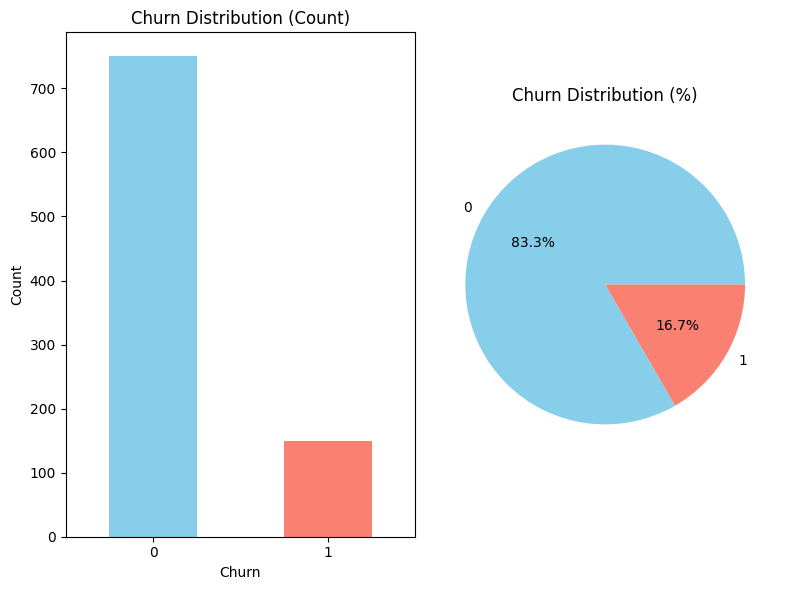

In [15]:
print("Churn Distribution:")
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"\nChurn Rate: {df['Churn'].mean():.2%}")

# Visualize churn distribution
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution (Count)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
churn_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Churn Distribution (%)')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [16]:
print("Missing values in each column:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️ Total missing values: {missing_values.sum()}")

Missing values in each column:
Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              0
dtype: int64

✅ No missing values found!


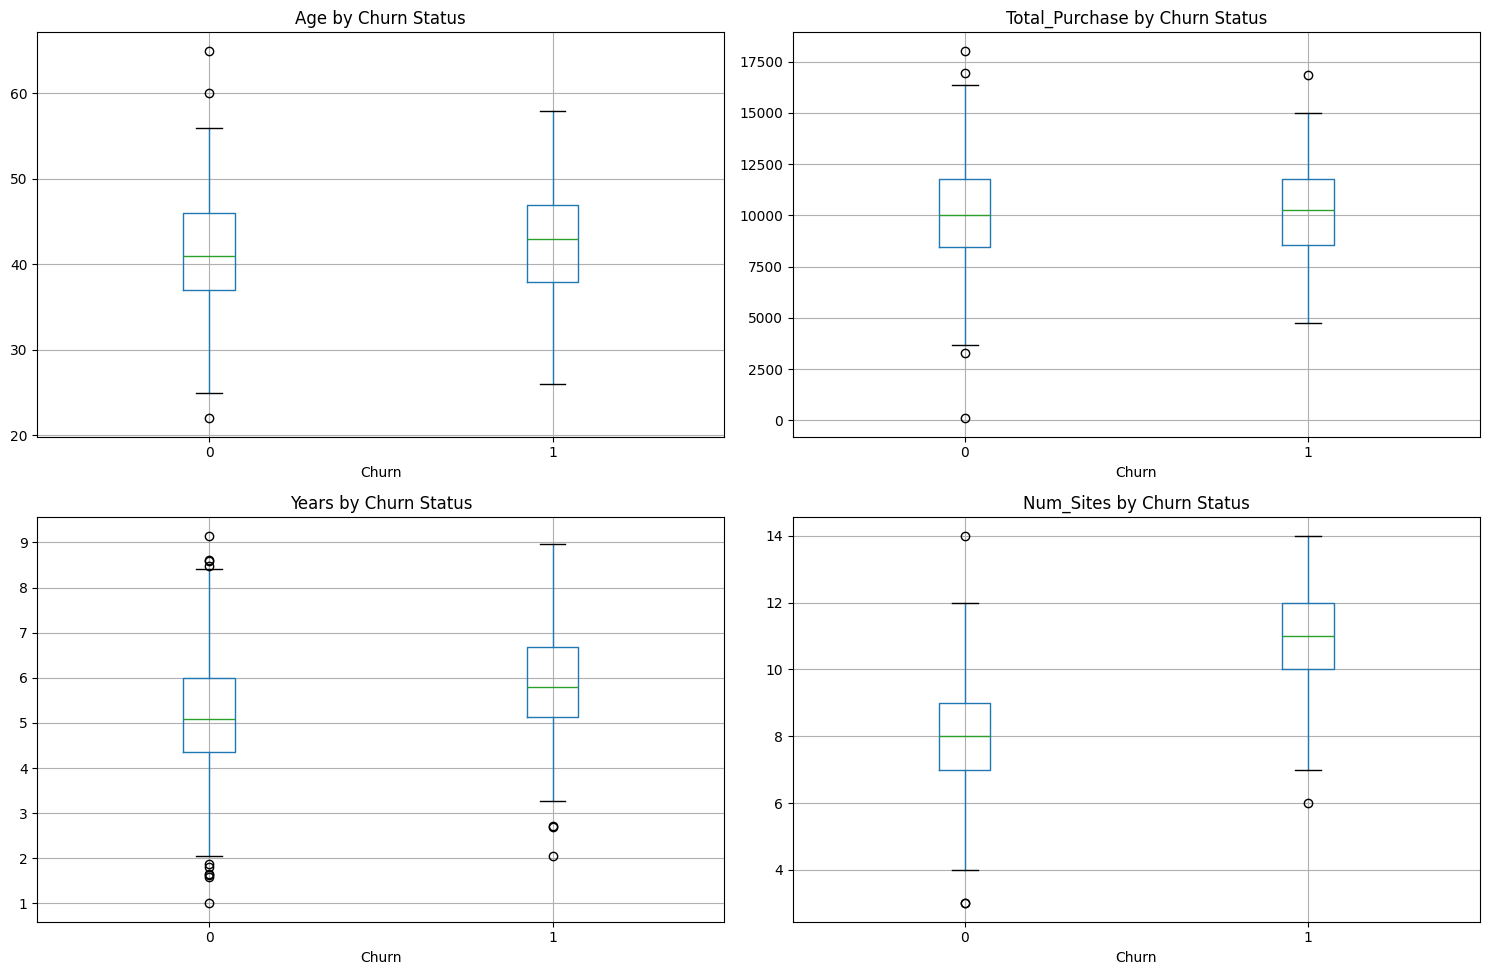

In [17]:
numerical_cols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    
    # Box plot by churn
    df.boxplot(column=col, by='Churn', ax=plt.gca())
    plt.title(f'{col} by Churn Status')
    plt.suptitle('')  # Remove default title
    
plt.tight_layout()
plt.show()


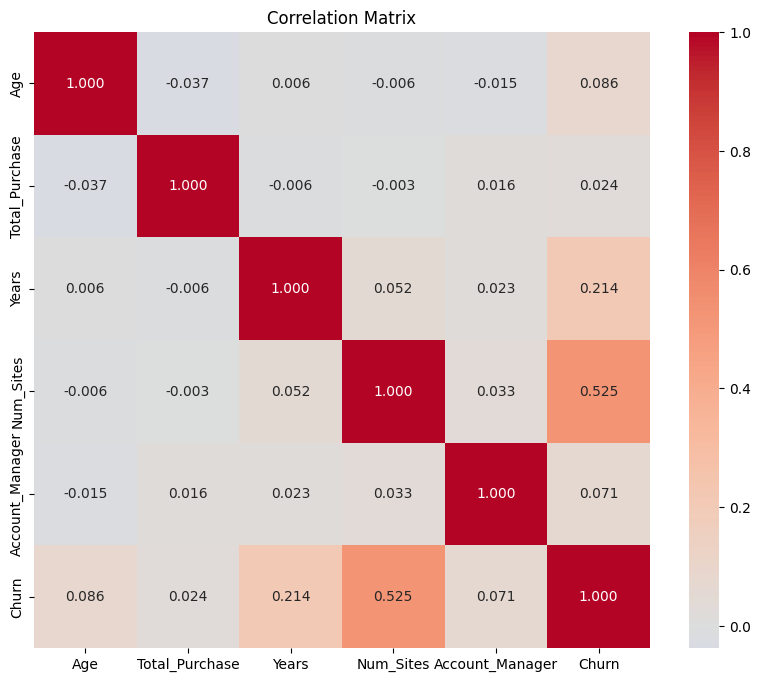

Correlation with Churn:
Churn              1.000000
Num_Sites          0.525398
Years              0.214329
Age                0.085926
Account_Manager    0.070611
Total_Purchase     0.024031
Name: Churn, dtype: float64


In [18]:
# Correlation matrix for numerical features
correlation_matrix = df[numerical_cols + ['Account_Manager', 'Churn']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

print("Correlation with Churn:")
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)
print(churn_correlation)

In [19]:
# Create a copy for processing
df_processed = df.copy()

print("Starting feature engineering...")

# 1. Date Processing - Extract features from Onboard_date
df_processed['Onboard_date'] = pd.to_datetime(df_processed['Onboard_date'])

# Calculate days since onboarding
reference_date = df_processed['Onboard_date'].max()
df_processed['Days_Since_Onboard'] = (reference_date - df_processed['Onboard_date']).dt.days

# Extract onboard year and month
df_processed['Onboard_Year'] = df_processed['Onboard_date'].dt.year
df_processed['Onboard_Month'] = df_processed['Onboard_date'].dt.month

print("✅ Date features created")

# 2. Financial Features
df_processed['Purchase_Per_Year'] = df_processed['Total_Purchase'] / (df_processed['Years'] + 0.1)
df_processed['Purchase_Per_Site'] = df_processed['Total_Purchase'] / (df_processed['Num_Sites'] + 0.1)

print("✅ Financial features created")

# 3. Engagement Features
df_processed['Sites_Per_Year'] = df_processed['Num_Sites'] / (df_processed['Years'] + 0.1)

print("✅ Engagement features created")

# 4. Customer Segmentation
# Age groups
df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                 bins=[0, 30, 45, 60, 100], 
                                 labels=['Young', 'Mid', 'Senior', 'Elder'])

# Purchase tiers
df_processed['Purchase_Tier'] = pd.qcut(df_processed['Total_Purchase'], 
                                      q=4, 
                                      labels=['Low', 'Medium', 'High', 'Premium'])

print("✅ Customer segmentation features created")

print(f"\nNew dataset shape: {df_processed.shape}")
print("New columns created:")
new_columns = [col for col in df_processed.columns if col not in df.columns]
print(new_columns)


Starting feature engineering...
✅ Date features created
✅ Financial features created
✅ Engagement features created
✅ Customer segmentation features created

New dataset shape: (900, 18)
New columns created:
['Days_Since_Onboard', 'Onboard_Year', 'Onboard_Month', 'Purchase_Per_Year', 'Purchase_Per_Site', 'Sites_Per_Year', 'Age_Group', 'Purchase_Tier']


In [20]:
# One-hot encoding for categorical variables
categorical_columns = ['Location', 'Company', 'Age_Group', 'Purchase_Tier']

print("Encoding categorical variables...")
print(f"Original categorical columns: {categorical_columns}")

# Create dummy variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_columns, prefix=categorical_columns)

print(f"After encoding - Dataset shape: {df_encoded.shape}")

# Remove unnecessary columns
columns_to_drop = ['Names', 'Onboard_date']
df_final = df_encoded.drop(columns=columns_to_drop)

print(f"Final dataset shape after removing unnecessary columns: {df_final.shape}")
print("\n✅ Data preprocessing completed!")

# ================================
# CELL 10: Prepare Data for Modeling
# ================================

# Separate features and target
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print("Features and target separated:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

print(f"\nOriginal class distribution:")
original_distribution = y.value_counts()
print(original_distribution)
print(f"Original churn rate: {y.mean():.2%}")


Encoding categorical variables...
Original categorical columns: ['Location', 'Company', 'Age_Group', 'Purchase_Tier']
After encoding - Dataset shape: (900, 1795)
Final dataset shape after removing unnecessary columns: (900, 1793)

✅ Data preprocessing completed!
Features and target separated:
Features shape: (900, 1792)
Target shape: (900,)

Original class distribution:
Churn
0    750
1    150
Name: count, dtype: int64
Original churn rate: 16.67%


Applying SMOTE to handle class imbalance...
After SMOTE:
Churn
0    750
1    525
Name: count, dtype: int64
Balanced churn rate: 41.18%


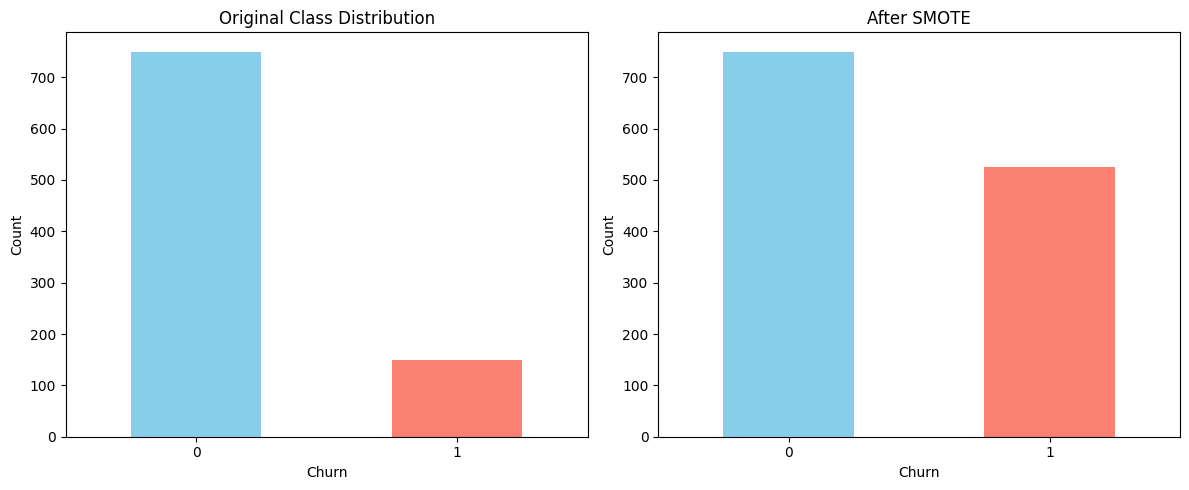

In [21]:
print("Applying SMOTE to handle class imbalance...")

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.7)  # 70% minority class ratio
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"After SMOTE:")
balanced_distribution = pd.Series(y_balanced).value_counts()
print(balanced_distribution)
print(f"Balanced churn rate: {pd.Series(y_balanced).mean():.2%}")

# Visualize the effect of SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
original_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Original Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
balanced_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('After SMOTE')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [22]:
# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print("Data split completed:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed!")


Data split completed:
Training set: (1020, 1792)
Test set: (255, 1792)
✅ Feature scaling completed!


In [23]:
print("Training Logistic Regression...")
print("=" * 50)

# Train model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
lr_auc = roc_auc_score(y_test, lr_prob)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

print("LOGISTIC REGRESSION RESULTS:")
print(f"ROC-AUC Score: {lr_auc:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, lr_pred))

Training Logistic Regression...
LOGISTIC REGRESSION RESULTS:
ROC-AUC Score: 0.9997
Precision: 0.9292
Recall: 1.0000
F1-Score: 0.9633

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       150
           1       0.93      1.00      0.96       105

    accuracy                           0.97       255
   macro avg       0.96      0.97      0.97       255
weighted avg       0.97      0.97      0.97       255



In [24]:
print("Training Decision Tree with Grid Search...")
print("=" * 50)

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

print("This may take a few minutes...")
dt_grid.fit(X_train, y_train)

# Best model
best_dt = dt_grid.best_estimator_
print(f"Best parameters: {dt_grid.best_params_}")

# Predictions
dt_pred = best_dt.predict(X_test)
dt_prob = best_dt.predict_proba(X_test)[:, 1]

# Evaluate
dt_auc = roc_auc_score(y_test, dt_prob)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

print("\nDECISION TREE RESULTS:")
print(f"ROC-AUC Score: {dt_auc:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1-Score: {dt_f1:.4f}")

Training Decision Tree with Grid Search...
This may take a few minutes...
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}

DECISION TREE RESULTS:
ROC-AUC Score: 0.9559
Precision: 0.9388
Recall: 0.8762
F1-Score: 0.9064


In [25]:
print("Training Neural Network with Grid Search...")
print("=" * 50)

# Hyperparameter tuning (smaller grid for faster execution)
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

nn_model = MLPClassifier(random_state=42, max_iter=500)
nn_grid = GridSearchCV(nn_model, nn_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

print("This may take a few minutes...")
nn_grid.fit(X_train_scaled, y_train)

# Best model
best_nn = nn_grid.best_estimator_
print(f"Best parameters: {nn_grid.best_params_}")

# Predictions
nn_pred = best_nn.predict(X_test_scaled)
nn_prob = best_nn.predict_proba(X_test_scaled)[:, 1]

# Evaluate
nn_auc = roc_auc_score(y_test, nn_prob)
nn_precision = precision_score(y_test, nn_pred)
nn_recall = recall_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)

print("\nNEURAL NETWORK RESULTS:")
print(f"ROC-AUC Score: {nn_auc:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-Score: {nn_f1:.4f}")


Training Neural Network with Grid Search...
This may take a few minutes...
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}

NEURAL NETWORK RESULTS:
ROC-AUC Score: 0.9886
Precision: 0.5615
Recall: 1.0000
F1-Score: 0.7192


MODEL COMPARISON


,Model,ROC-AUC,Precision,Recall,F1-Score
0,Logistic Regression,0.9997,0.9292,1.0000,0.9633
1,Decision Tree,0.9559,0.9388,0.8762,0.9064
2,Neural Network,0.9886,0.5615,1.0000,0.7192



🏆 Best performing model: Logistic Regression
🏆 Best ROC-AUC Score: 0.9997


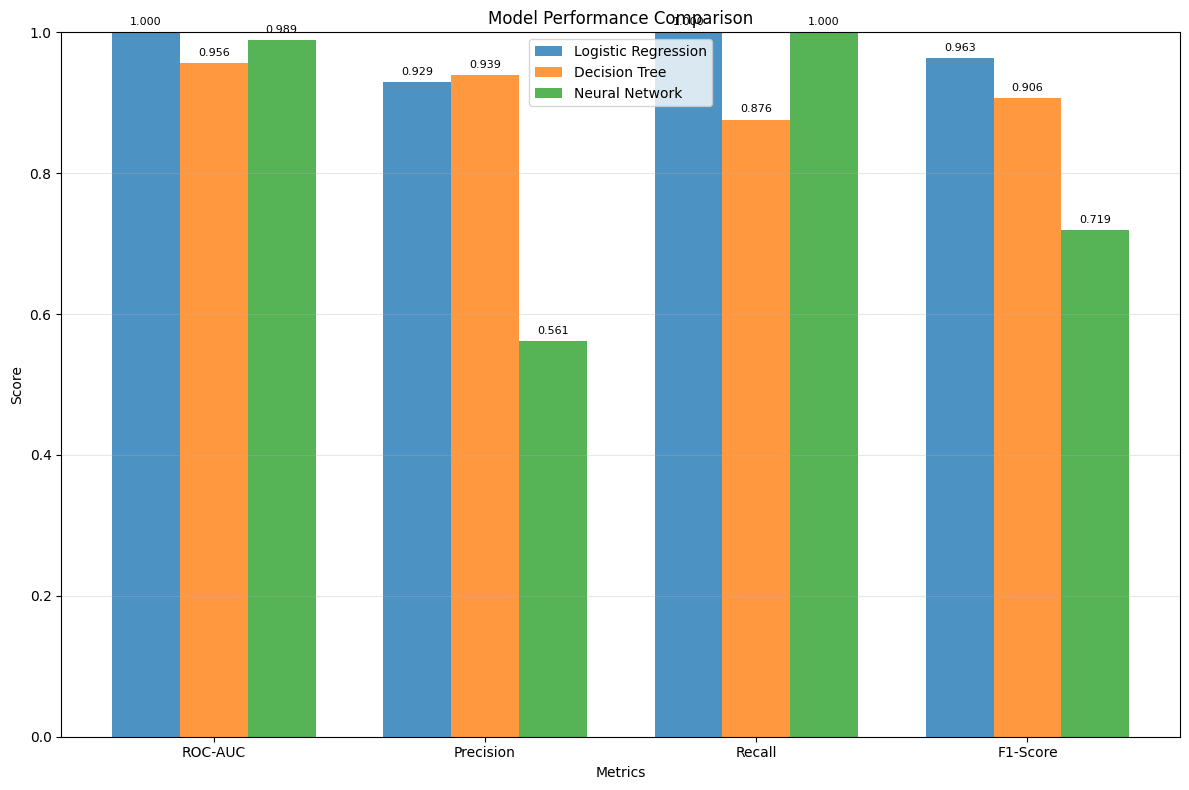

In [26]:
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Neural Network'],
    'ROC-AUC': [lr_auc, dt_auc, nn_auc],
    'Precision': [lr_precision, dt_precision, nn_precision],
    'Recall': [lr_recall, dt_recall, nn_recall],
    'F1-Score': [lr_f1, dt_f1, nn_f1]
})

display(comparison_df.round(4))

# Find best model
best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_auc = comparison_df.loc[best_model_idx, 'ROC-AUC']

print(f"\n🏆 Best performing model: {best_model_name}")
print(f"🏆 Best ROC-AUC Score: {best_auc:.4f}")

# Visualize comparison
plt.figure(figsize=(12, 8))

metrics = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, [lr_auc, lr_precision, lr_recall, lr_f1], width, label='Logistic Regression', alpha=0.8)
plt.bar(x, [dt_auc, dt_precision, dt_recall, dt_f1], width, label='Decision Tree', alpha=0.8)
plt.bar(x + width, [nn_auc, nn_precision, nn_recall, nn_f1], width, label='Neural Network', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, metric in enumerate(metrics):
    plt.text(i-width, [lr_auc, lr_precision, lr_recall, lr_f1][i] + 0.01, 
             f'{[lr_auc, lr_precision, lr_recall, lr_f1][i]:.3f}', ha='center', fontsize=8)
    plt.text(i, [dt_auc, dt_precision, dt_recall, dt_f1][i] + 0.01, 
             f'{[dt_auc, dt_precision, dt_recall, dt_f1][i]:.3f}', ha='center', fontsize=8)
    plt.text(i+width, [nn_auc, nn_precision, nn_recall, nn_f1][i] + 0.01, 
             f'{[nn_auc, nn_precision, nn_recall, nn_f1][i]:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

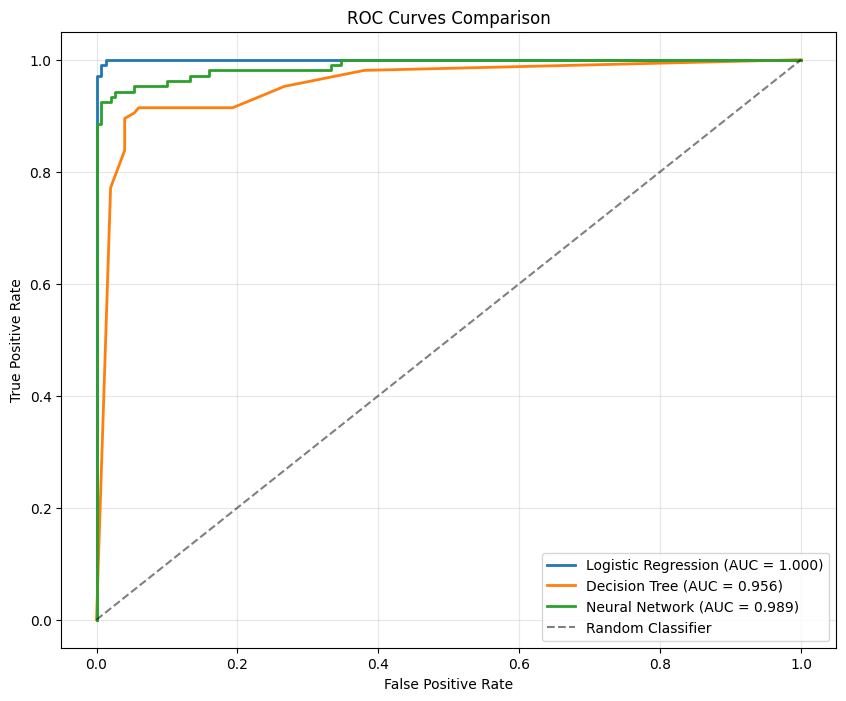

In [27]:
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})', linewidth=2)

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_auc:.3f})', linewidth=2)

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_prob)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_auc:.3f})', linewidth=2)

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


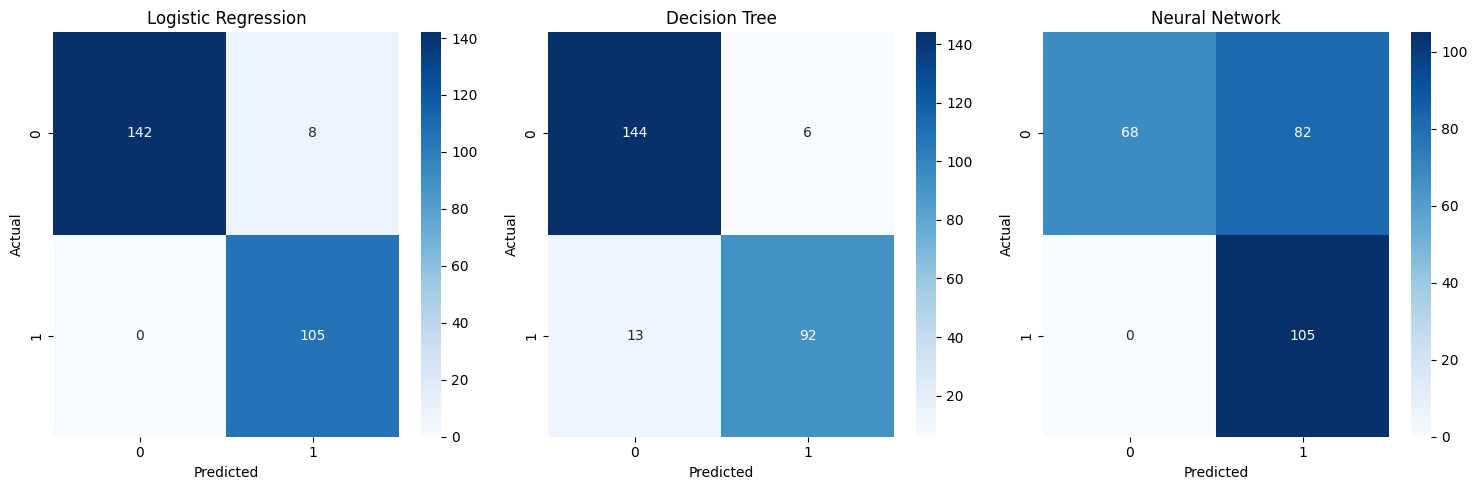

In [28]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree
cm_dt = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Decision Tree')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Neural Network
cm_nn = confusion_matrix(y_test, nn_pred)
sns.heatmap(cm_nn, annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [29]:
# Select the best model based on ROC-AUC
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    use_scaling = True
elif best_model_name == 'Decision Tree':
    best_model = best_dt
    use_scaling = False
else:  # Neural Network
    best_model = best_nn
    use_scaling = True

print(f"Selected best model: {best_model_name}")

# Function to predict churn for new customers
def predict_churn_risk(customer_data_dict):
    """
    Predict churn risk for a new customer
    
    Parameters:
    customer_data_dict: Dictionary with customer features
    Example: {
        'Age': 35,
        'Total_Purchase': 5000,
        'Account_Manager': 1,
        'Years': 2.5,
        'Num_Sites': 3,
        # ... other features
    }
    """
    
    # Convert dictionary to DataFrame
    customer_df = pd.DataFrame([customer_data_dict])
    
    # Apply the same preprocessing as training data
    # (You would need to apply the same feature engineering steps)
    
    # For now, assuming the customer_data already has all processed features
    customer_features = customer_df[feature_names]
    
    # Scale if needed
    if use_scaling:
        customer_scaled = scaler.transform(customer_features)
        churn_prob = best_model.predict_proba(customer_scaled)[0, 1]
    else:
        churn_prob = best_model.predict_proba(customer_features)[0, 1]
    
    # Assign risk category
    if churn_prob >= 0.7:
        risk_level = "High Risk"
        action = "Immediate intervention required - Contact customer ASAP"
    elif churn_prob >= 0.4:
        risk_level = "Medium Risk"
        action = "Monitor closely and engage with retention offers"
    else:
        risk_level = "Low Risk"
        action = "Standard engagement and monitoring"
    
    return {
        'churn_probability': round(churn_prob, 4),
        'risk_level': risk_level,
        'recommended_action': action
    }

print("✅ Prediction function created!")
print("\nTo predict for a new customer, use:")
print("result = predict_churn_risk(customer_data_dict)")


Selected best model: Logistic Regression
✅ Prediction function created!

To predict for a new customer, use:
result = predict_churn_risk(customer_data_dict)


In [32]:
print("=" * 60)
print("CHURN PREDICTION MODEL - FINAL RESULTS")
print("=" * 60)

print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {best_auc:.4f}")

display(comparison_df.round(4))

print("\n✅ CHURN PREDICTION PIPELINE COMPLETED SUCCESSFULLY!")

CHURN PREDICTION MODEL - FINAL RESULTS
Best Model: Logistic Regression
ROC-AUC Score: 0.9997


,Model,ROC-AUC,Precision,Recall,F1-Score
0,Logistic Regression,0.9997,0.9292,1.0000,0.9633
1,Decision Tree,0.9559,0.9388,0.8762,0.9064
2,Neural Network,0.9886,0.5615,1.0000,0.7192



✅ CHURN PREDICTION PIPELINE COMPLETED SUCCESSFULLY!
